In [1]:
%cd ..

/Users/pedrobedmar/GoogleDrive/MASTER_BIG_DATA/tfm/code


In [29]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import shap

import lab.functions as func
from etl.esios.provider import ESIOSDataProvider
from etl.generic_provider import GenericDataProvider

from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR

SEED=0
np.random.seed(SEED)
save_path = "lab/models/hourly/"

In [30]:
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300

In [31]:
forecasting_horizon = 12
fh = list(range(1, forecasting_horizon+1))

In [32]:
esios_provider = ESIOSDataProvider()
esios_tickers = esios_provider.get_tickers()
print(esios_tickers)

investingdotcom_tickers = ["DAILY_TTF_PRICE", "MONTHLY_TTF_PRICE"]
investingdotcom_provider = GenericDataProvider("datalake/clean/investingdotcom/", want_metadata=False, tickers=investingdotcom_tickers)
print(investingdotcom_tickers)

marketwatch_tickers = ["DAILY_COAL_PRICE"]
marketwatch_provider = GenericDataProvider("datalake/clean/marketwatch/", want_metadata=False, tickers=marketwatch_tickers)
print(marketwatch_tickers)

icap_tickers = ["CO2_EUA_PRICE"]
icap_provider = GenericDataProvider("datalake/clean/ICAP/", want_metadata=False, tickers=icap_tickers)
print(icap_tickers)

['DEMANDA_REAL', 'GENERACIÓN_MEDIDA_TOTAL', 'GENERACIÓN_MEDIDA_EÓLICA', 'GENERACIÓN_MEDIDA_HIDRÁULICA', 'GENERACIÓN_MEDIDA_NUCLEAR', 'GENERACIÓN_MEDIDA_SOLAR', 'GENERACIÓN_MEDIDA_CICLO_COMBINADO', 'GENERACIÓN_MEDIDA_CARBÓN', 'PRECIO_MERCADO_SPOT_DIARIO']
['DAILY_TTF_PRICE', 'MONTHLY_TTF_PRICE']
['DAILY_COAL_PRICE']
['CO2_EUA_PRICE']


## Postpandemic

In [39]:
best_model = RandomForestRegressor()
start_index="2014-01"
end_index="2023-03"

In [40]:
esios_spot = esios_provider.get_series("PRECIO_MERCADO_SPOT_DIARIO", freq="H", start_index=start_index, end_index=end_index, resample_by="M", group_mode="mean")
esios_df = esios_provider.get_all_series(freq="H", start_index=start_index, end_index=end_index, resample_by="M", group_mode="sum")
ttf_df = investingdotcom_provider.get_series(investingdotcom_tickers[1], freq="M", start_index=start_index, end_index=end_index)
coal_df = marketwatch_provider.get_series(marketwatch_tickers[0], freq="D", start_index=start_index, end_index=end_index, resample_by="M", group_mode="mean")
co2_df = icap_provider.get_series(icap_tickers[0], freq="D", start_index=start_index, end_index=end_index, resample_by="M", group_mode="mean")

contamination = 0.01
esios_df = func.remove_outliers_isolation_forests(esios_df, contamination)

X = esios_df.drop(['PRECIO_MERCADO_SPOT_DIARIO', 'GENERACIÓN_MEDIDA_TOTAL'], axis=1)
X = pd.concat([X, ttf_df, coal_df, co2_df], axis=1)
lags = [1, 2, 5, 6, 11, 12]
date_features = ["month", "year"]

### 1 hour forecast horizon

In [41]:
shap_values_first_postpandemic = func.predictors_influence_study(esios_spot, X, best_model, lags, date_features, forecasting_horizon, version="first", seed=SEED)

Prediction MASE: 16.385046036916837


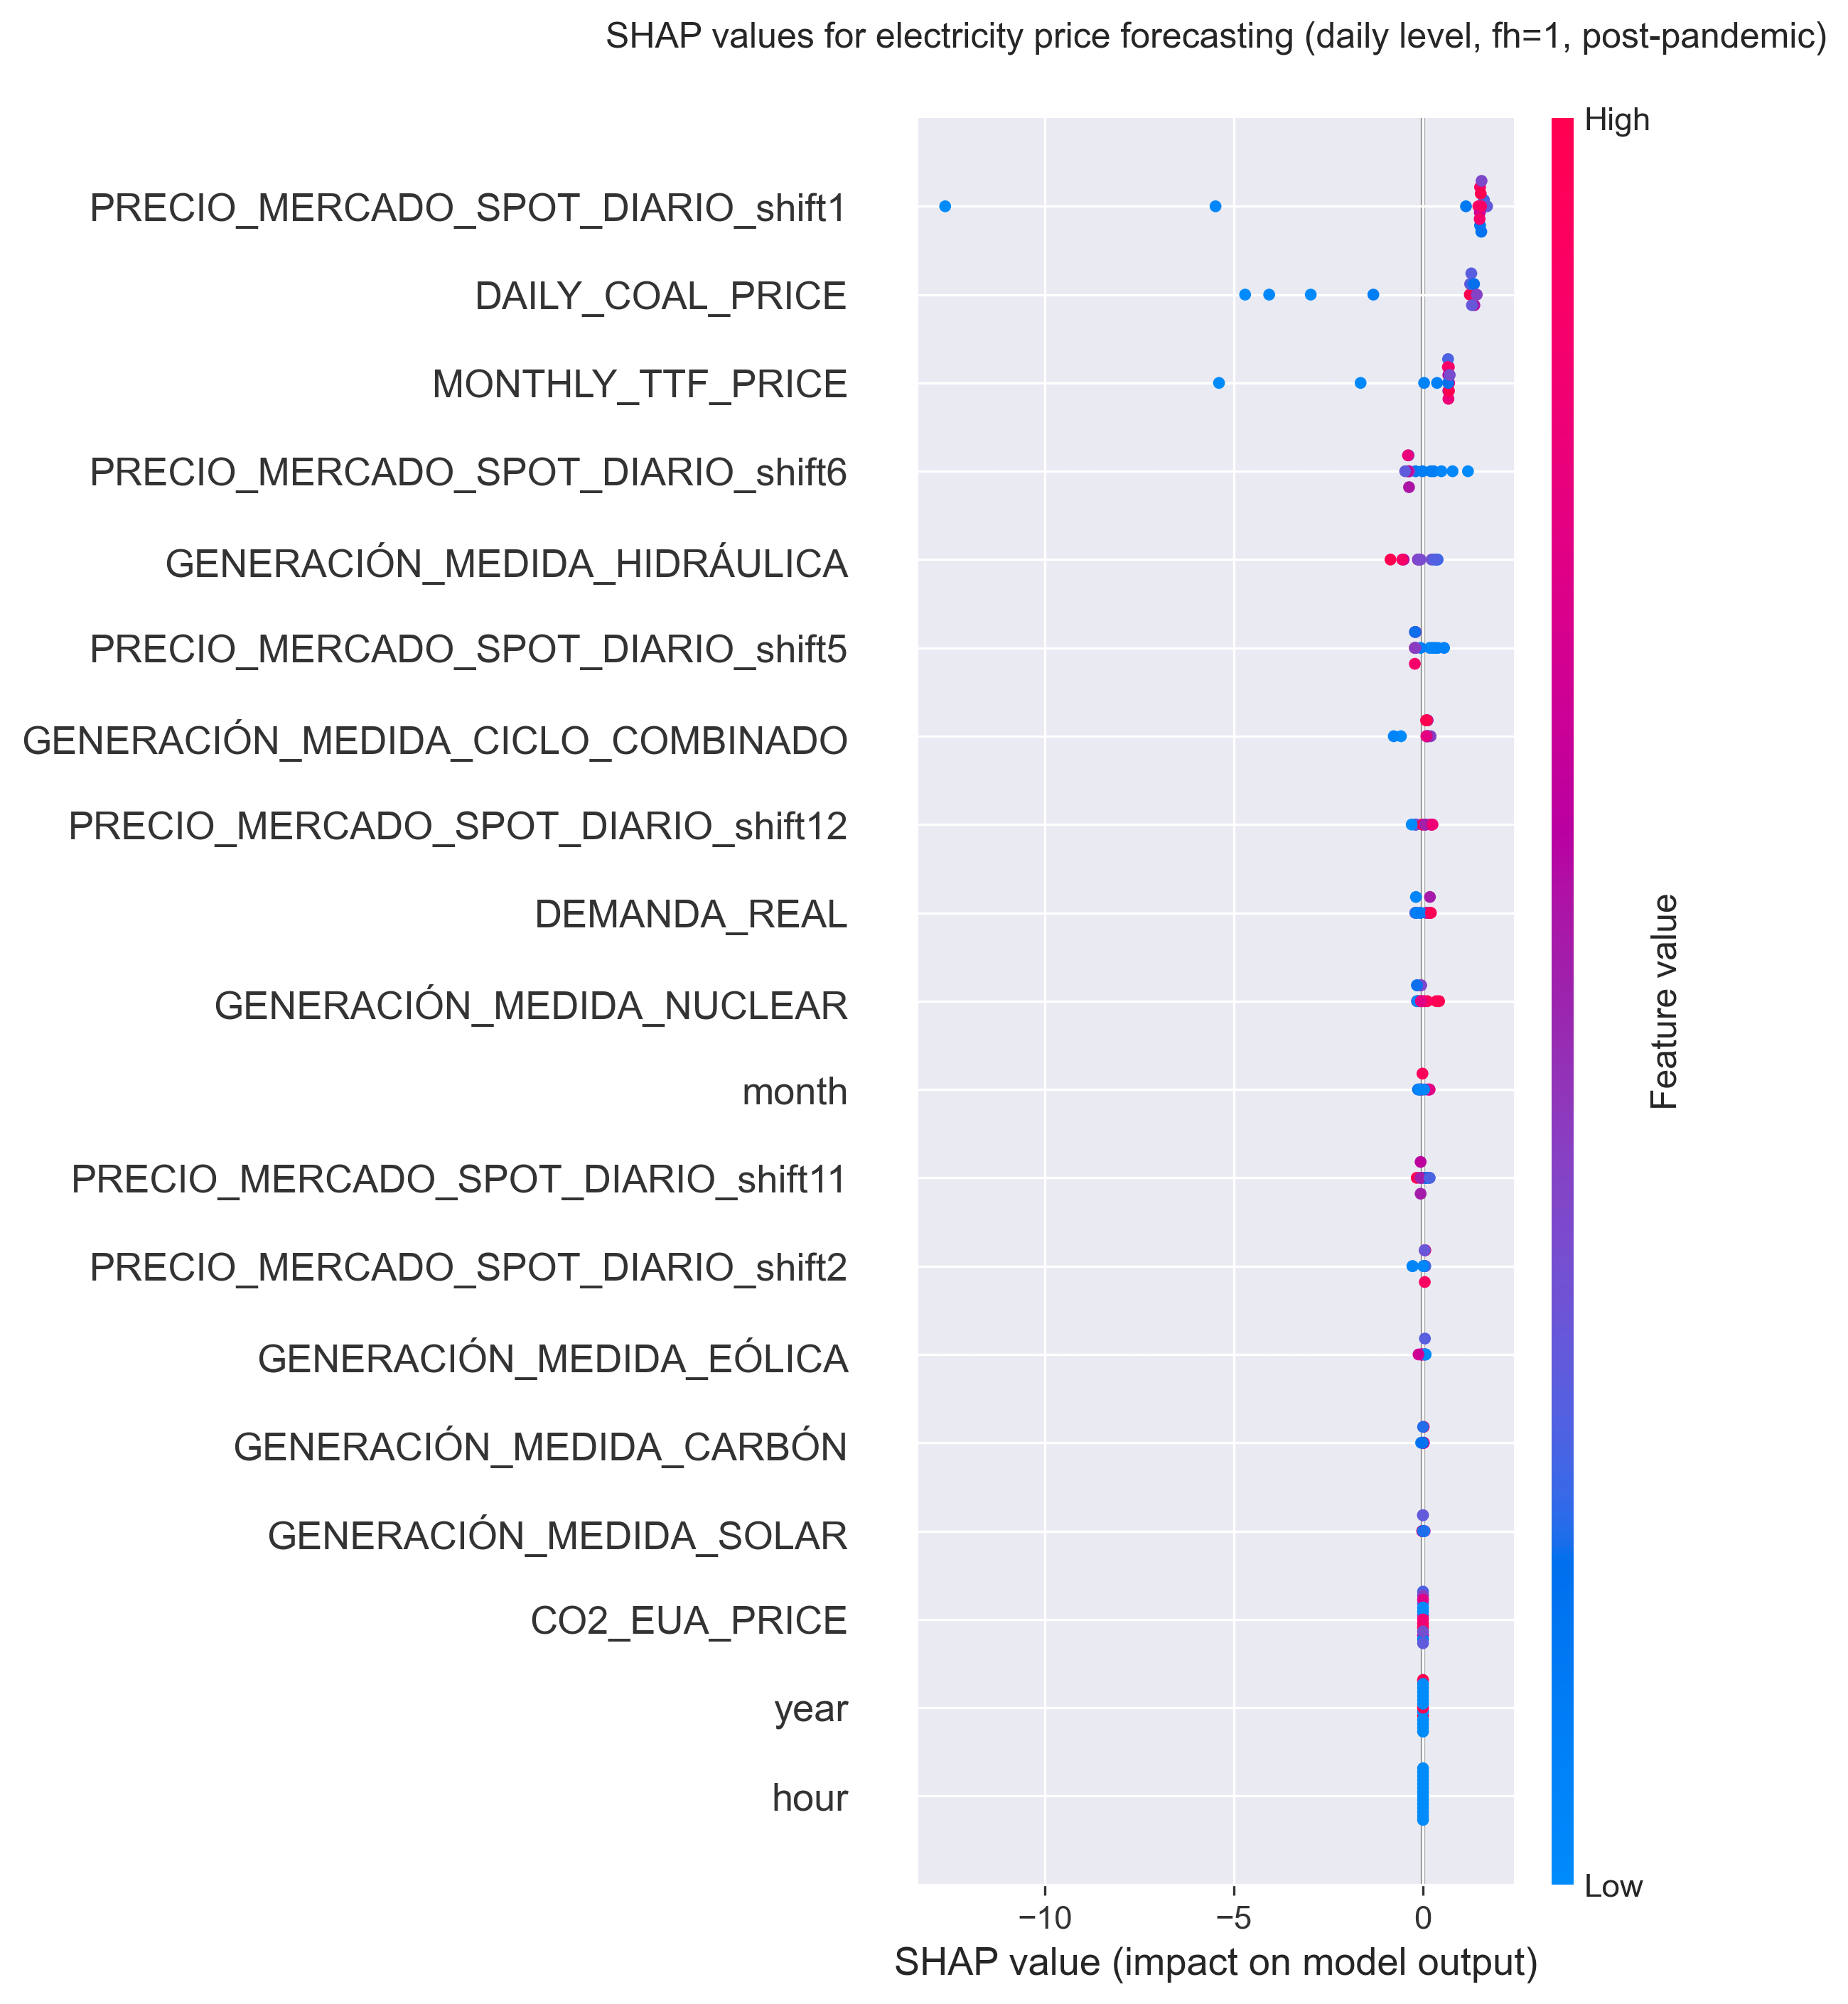

In [42]:
shap.summary_plot(shap_values_first_postpandemic, show=False)
plt.title("SHAP values for electricity price forecasting (daily level, fh=1, post-pandemic)", y=1.03)
plt.show()

### 168 hours forecast horizon

In [43]:
shap_values_last_postpandemic = func.predictors_influence_study(esios_spot, X, best_model, lags, date_features, forecasting_horizon, version="last", seed=SEED)

Prediction MASE: 5.707002675207511


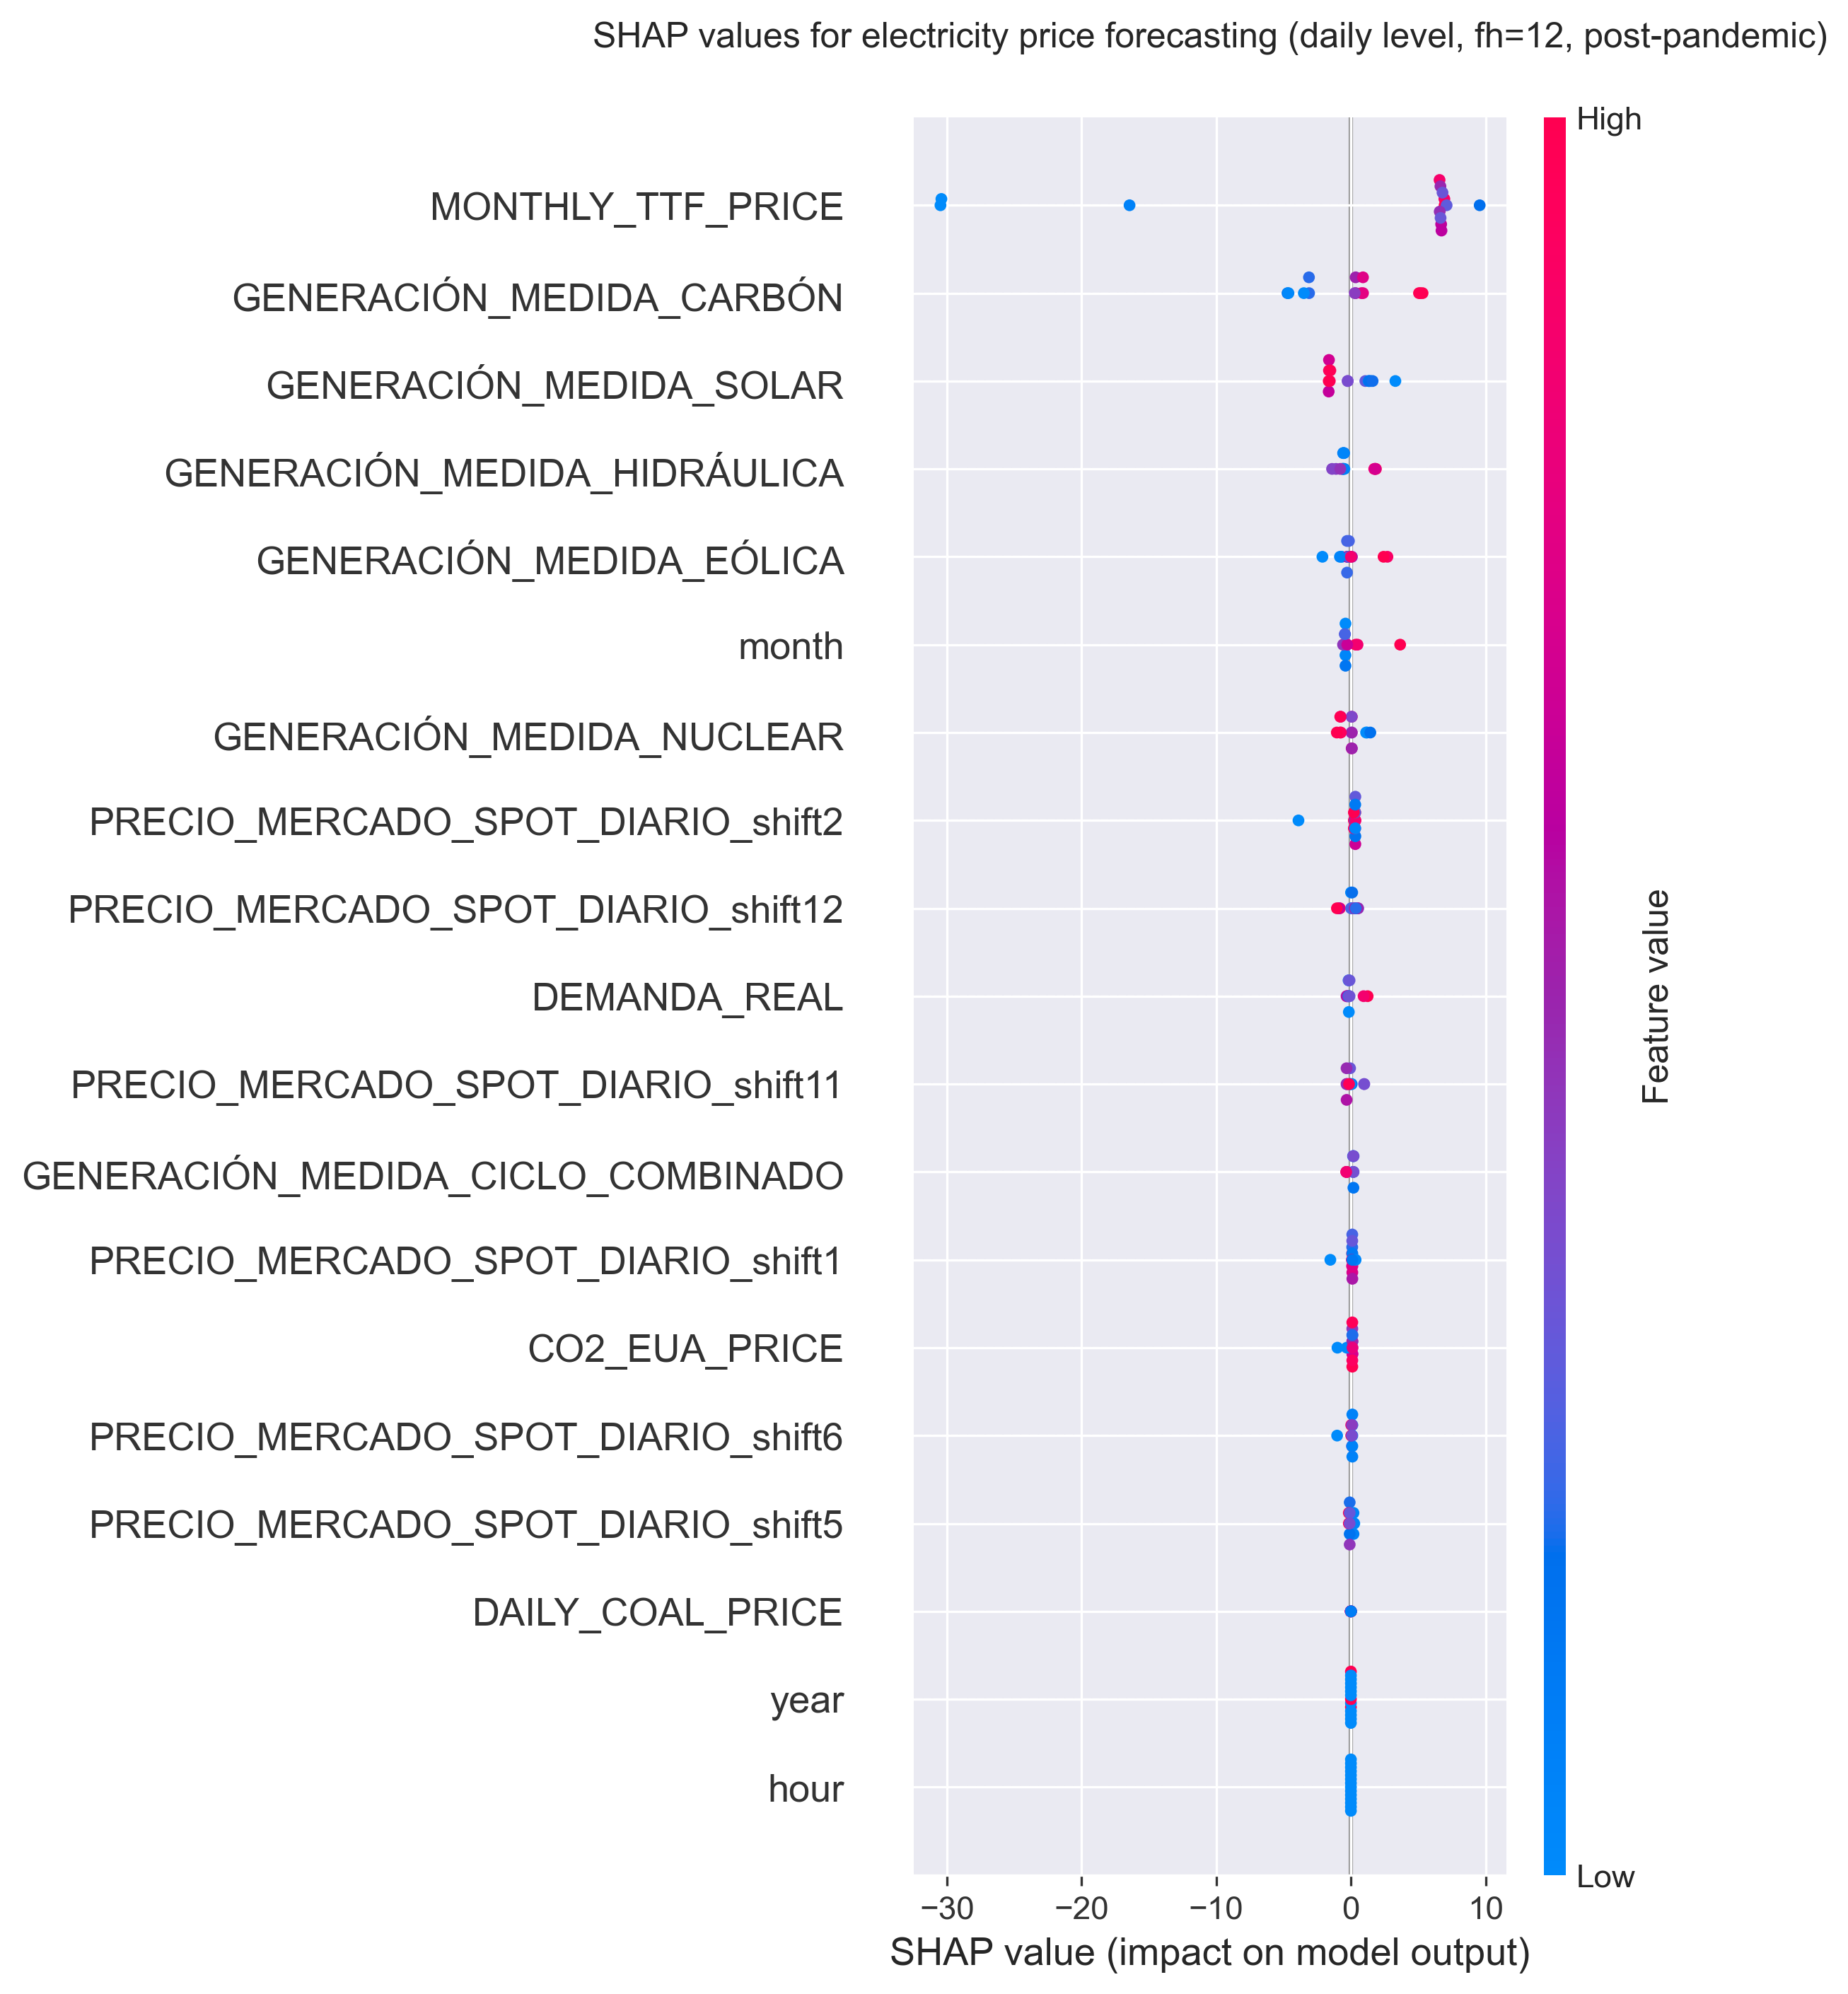

In [44]:
shap.summary_plot(shap_values_last_postpandemic, show=False)
plt.title(f"SHAP values for electricity price forecasting (daily level, fh={forecasting_horizon}, post-pandemic)", y=1.03)
plt.show()